In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
path='/content/drive/Shareddrives/Deep Learning/Data/cleaned_data.csv'
df=pd.read_csv(path)

In [ ]:
df.head()

,qid1,qid2,question1_cleaned,question2_cleaned,is_duplicate
0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,7,8,why am i mentally very lonely how can i solve it,find the remainder when 23 24 math is divi...,0
4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0


#Glove Emebedding with Siamese Network

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load pre-trained GloVe embeddings
glove_embeddings_path = '/content/drive/Shareddrives/Deep Learning/Embedding File/glove.6B.100d.txt'

# Load the GloVe embeddings into memory
embeddings_index = {}
with open(glove_embeddings_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


In [ ]:
# Convert all values in 'question1_cleaned' and 'question2_cleaned' columns to strings
df['question1_cleaned'] = df['question1_cleaned'].astype(str)
df['question2_cleaned'] = df['question2_cleaned'].astype(str)

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['question1_cleaned'].values + df['question2_cleaned'].values)
X = tokenizer.texts_to_sequences(df['question1_cleaned'].values + df['question2_cleaned'].values)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

max_len = 50
q1_texts_seq = tokenizer.texts_to_sequences(df['question1_cleaned'].values)
q2_texts_seq = tokenizer.texts_to_sequences(df['question2_cleaned'].values)

q1_texts_seq = pad_sequences(q1_texts_seq, maxlen=max_len)
q2_texts_seq = pad_sequences(q2_texts_seq, maxlen=max_len)
X = np.stack((q1_texts_seq, q2_texts_seq), axis=1)

y = df["is_duplicate"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get Question 1/2 train and test features
q1_X_train = X_train[:,0]
q2_X_train = X_train[:,1]

q1_X_test = X_test[:,0]
q2_X_test = X_test[:,1]


Vocabulary Size: 175861


In [ ]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout

# Define Siamese model architecture
embedding_dim = 100  # Assuming you're using GloVe embeddings of dimension 100

# Define input layers
input_q1 = Input(shape=(max_len,))
input_q2 = Input(shape=(max_len,))

# Define embedding layers using GloVe embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)

embedded_q1 = embedding_layer(input_q1)
embedded_q2 = embedding_layer(input_q2)

# Define GRU layers
gru_layer = GRU(64, dropout=0.5, recurrent_dropout=0.5)

# Process question 1 and question 2 separately through GRU layers
gru_output_q1 = gru_layer(embedded_q1)
gru_output_q2 = gru_layer(embedded_q2)

# Concatenate the outputs
merged_output = concatenate([gru_output_q1, gru_output_q2])

# Define dense layers
dense_layer_1 = Dense(64, activation='relu')(merged_output)
dropout_layer = Dropout(0.5)(dense_layer_1)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)

In [ ]:
# Define the model
siamese_model = Model(inputs=[input_q1, input_q2], outputs=output_layer)

# Compile the model
siamese_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 100)              1758610   ['input_1[0][0]',             
                                                          0          'input_2[0][0]']             
                                                                                                  
 gru (GRU)                   (None, 64)                   31872     ['embedding[0][0]',       

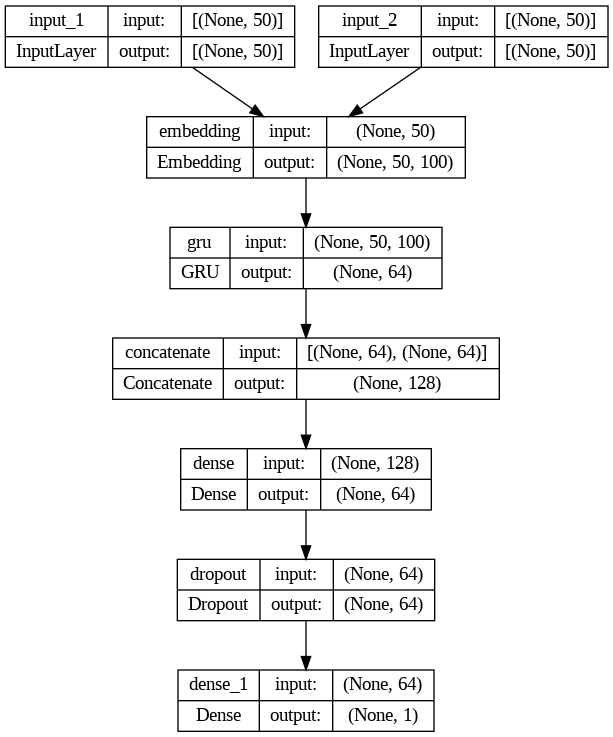

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(siamese_model, to_file='model.png', show_shapes=True)

In [ ]:
# Train the model
history = siamese_model.fit([q1_X_train, q2_X_train], y_train, batch_size=64, epochs=20, validation_split=0.1)



Epoch 1/20
4549/4549 [==============================] - 769s 168ms/step - loss: 0.5822 - accuracy: 0.6907 - val_loss: 0.5247 - val_accuracy: 0.7381
Epoch 2/20
4549/4549 [==============================] - 753s 166ms/step - loss: 0.5389 - accuracy: 0.7229 - val_loss: 0.4935 - val_accuracy: 0.7515
Epoch 3/20
4549/4549 [==============================] - 725s 159ms/step - loss: 0.5232 - accuracy: 0.7322 - val_loss: 0.4967 - val_accuracy: 0.7526
Epoch 4/20
4549/4549 [==============================] - 728s 160ms/step - loss: 0.5148 - accuracy: 0.7380 - val_loss: 0.5023 - val_accuracy: 0.7464
Epoch 5/20
4549/4549 [==============================] - 765s 168ms/step - loss: 0.5094 - accuracy: 0.7422 - val_loss: 0.4763 - val_accuracy: 0.7622
Epoch 6/20
4549/4549 [==============================] - 813s 179ms/step - loss: 0.5062 - accuracy: 0.7436 - val_loss: 0.4672 - val_accuracy: 0.7656
Epoch 7/20
4549/4549 [==============================] - 814s 179ms/step - loss: 0.5024 - accuracy: 0.7457 - val_

#Visualization for learning curves

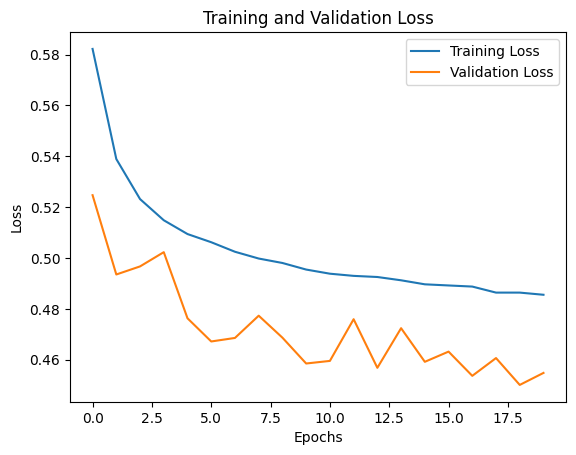

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

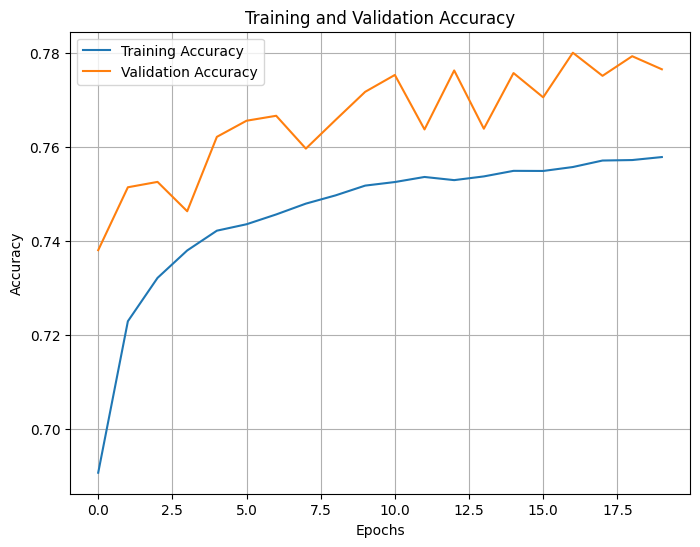

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation accuracy from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#Saving the Siamese Model

In [ ]:
import pickle

# Choose a File Path
siamese_model_file_path = '/content/drive/Shareddrives/Deep Learning/Code File/Siamesemodel.h5'
siamese_tokenizer_file_path = '/content/drive/Shareddrives/Deep Learning/Code File/Siamesetokenizer.pkl'

# Save the Model
siamese_model.save(siamese_model_file_path)

#  Save the Tokenizer
with open(siamese_tokenizer_file_path, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Loading the model

In [13]:
import pickle
from tensorflow.keras.models import load_model

# File paths for the saved model and tokenizer
siamese_model_file_path  = '/content/drive/Shareddrives/Deep Learning/Code File/Siamesemodel.h5'
siamese_tokenizer_file_path = '/content/drive/Shareddrives/Deep Learning/Code File/Siamesetokenizer.pkl'

#  Load the Model
siamese_loaded_model = load_model(siamese_model_file_path)

#  Load the Tokenizer
with open(siamese_tokenizer_file_path, 'rb') as tokenizer_file:
    loaded_tokenizer = pickle.load(tokenizer_file)


#Model Evaluation

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report

# Evaluate the model on test data
test_loss, test_accuracy = siamese_loaded_model.evaluate([q1_X_test, q2_X_test], y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Predict the labels for test data
y_pred = siamese_loaded_model.predict([q1_X_test, q2_X_test])
y_pred = (y_pred > 0.5).astype(int)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


2527/2527 [==============================] - 58s 22ms/step - loss: 0.4570 - accuracy: 0.7735
Test Loss: 0.4569717347621918
Test Accuracy: 0.7734670639038086
2527/2527 [==============================] - 63s 25ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81     50803
           1       0.68      0.75      0.71     30055

    accuracy                           0.77     80858
   macro avg       0.76      0.77      0.76     80858
weighted avg       0.78      0.77      0.78     80858



#Model Prediction

In [ ]:
def preprocess_text(text):
    # Tokenize the text
    sequence = tokenizer.texts_to_sequences([text])
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    return padded_sequence

def predict_similarity(text1, text2):
    # Preprocess the input texts
    processed_text1 = preprocess_text(text1)
    processed_text2 = preprocess_text(text2)
    # Predict similarity using the trained model
    similarity = siamese_loaded_model.predict([processed_text1, processed_text2])[0][0]
    return similarity

def classify_paraphrase(text1, text2, threshold=0.7):
    similarity_score = predict_similarity(text1, text2)
    if similarity_score >= threshold:
        classification = "These questions are paraphrased."
    else:
        classification = "These questions are not paraphrased."
    return classification, similarity_score

# Interactive loop to take input from the user
while True:
    text1 = input("Enter the first question (or type 'quit' to exit): ")
    if text1.lower() == 'quit':
        print("Exiting...")
        break
    text2 = input("Enter the second question: ")
    if text1.lower() == text2.lower():
        print("These questions are exactly the same (Case insensitive)")
        print("Similarity Score: 1.0000000")
        continue

    # Classify as paraphrase or not
    result, similarity_score = classify_paraphrase(text1, text2)
    print(result)
    print("Similarity Score:", similarity_score)

Enter the first question (or type 'quit' to exit): How to learn machine learning ?
Enter the second question: Is machine learning difficult?
1/1 [==============================] - 1s 847ms/step
These questions are not paraphrased.
Similarity Score: 0.5980926
Enter the first question (or type 'quit' to exit): How does photosynthesis works?
Enter the second question: What is the process of photosynthesis?
1/1 [==============================] - 0s 34ms/step
These questions are not paraphrased.
Similarity Score: 0.32971272
Enter the first question (or type 'quit' to exit): exit
